In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [134]:
from scipy.spatial import distance_matrix

## Load data

In [2]:
from helper import load_data, normalize_data

data = load_data()
data.shape

(272, 2)

### Initialize your cluster centers

In [69]:
def initialize_clusters(data, k):
    """initialize the k cluster centers (the means).
    input:
        data: original data with shape (num_sample, num_feature).
        k: predefined number of clusters for the k-means algorithm.
    output:
        a numpy array with shape (k, num_feature)
    """
    # ***************************************************************************************************
    # INSERT YOUR CODE HERE
    # TODO: initialize cluster centers.
    # TODO: Make sure you choose k clusters from the data itself,
    #       or ensure otherwise that your initializations have the same scaling as the data
    # ***************************************************************************************************
    ids = np.random.choice(data.shape[0], size=k)
    return data[ids, :]

### Update k-means parameters

#### Build distance matrix
Build a distance matrix, collecting the distances of the original dataset to the means of the clusters.

NOTE: once you finish your `build_distance_matrix`, please copy the function to the `helper.py` function. Otherwise, the `kmeans` function will not work.

In [138]:
def build_distance_matrix(data, mu):
    """build a distance matrix.
    return
        distance matrix:
            row of the matrix represents the data point,
            column of the matrix represents the k-th cluster.
    """
    # Inefficient implementation
    dmx = np.zeros((data.shape[0], mu.shape[0]))
    for i in range(data.shape[0]):
        for j in range(mu.shape[0]):
            dmx[i, j] = np.sqrt(np.power(data[i] - mu[j], 2).sum())
    
    return dmx

In [141]:
datatest = np.array([
    [1.0, 0.0],
    [0.0, 1.0],
    [1.0, 1.0]
])
mutest = np.array([
    [0.0, 0.0],
    [1.0, 1.0]
])
build_distance_matrix(datatest, mutest)

array([[1.        , 1.        ],
       [1.        , 1.        ],
       [1.41421356, 0.        ]])

In [135]:
distance_matrix(datatest, mutest)

array([[1.        , 1.        ],
       [1.        , 1.        ],
       [1.41421356, 0.        ]])

In [136]:
datatest = np.random.randn(1000, 2)

In [137]:
%%timeit
distance_matrix(datatest, mutest)

53.7 µs ± 260 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [139]:
%%timeit
build_distance_matrix(datatest, mutest)

9.29 ms ± 26.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


It's pointless to implement it with for loops. Moreover, plenty of implementations exist to vectorize those computations, so we'll use `scipy.spatial.distance_matrix` instead:

In [140]:
def build_distance_matrix(data, mu):
    """build a distance matrix.
    return
        distance matrix:
            row of the matrix represents the data point,
            column of the matrix represents the k-th cluster.
    """
    return distance_matrix(data, mu)

In [142]:
datatest = np.array([
    [1.0, 0.0],
    [0.0, 1.0],
    [1.0, 1.0]
])
mutest = np.array([
    [0.0, 0.0],
    [1.0, 1.0]
])
build_distance_matrix(datatest, mutest)

array([[1.        , 1.        ],
       [1.        , 1.        ],
       [1.41421356, 0.        ]])

#### Update k-means parameters

---

Formulas:

$$\mathcal L (\mathbf z, \boldsymbol \mu) = \sum_{n=1}^N \sum_{k=1}^K z_{nk} \Vert \mathbf x_n - \boldsymbol \mu_k \Vert_2^2$$

where

$$
\boldsymbol \mu = [ \boldsymbol \mu_1, \dots, \boldsymbol \mu_K]^\top\\
\mathbf z = [\mathbf z_1, \dots, \mathbf z_N]^\top\\
\mathbf z_n = [z_{n1}, \dots, z_{nK}]^\top
$$

and the following constraints:

$$
z_{nk} \in \{0, 1\}, \; \sum_{k=1}^K z_{nk} = 1
$$

The update is in two steps:

1. For all data points $n$, we assign a new cluster:

$$z_{nk} = 
\begin{cases}
1 & \text{if } k = \text{argmin}_j \Vert \mathbf x_n - \boldsymbol \mu_j \Vert^2_2 \\
0 & \text{otherwise}
\end{cases}$$

2. For each cluster, recompute the new centers:

$$\boldsymbol \mu_k = \frac
{\sum_{n=1}^N z_{nk} \mathbf x_n}
{\sum_{n=1}^N z_{nk}}
$$

We can formulate the loss in matrix form:

$$
\mathcal L (\mathbf z, \boldsymbol \mu)  = \left\Vert \mathbf X^\top - \mathbf M \mathbf Z^\top \right\Vert_\text{Frob}^2
$$

But we're asked to return a vector of loss *per sample*:

$$\begin{align}
\mathcal L_n &= \sum_{k=1}^K z_{nk} \Vert \mathbf x_n - \boldsymbol \mu_k \Vert_2^2\\
&= \sum_{k=1}^K z_{nk} d_{nk}\\
&= \left(\mathbf z_n \odot \mathbf d_n \right)_{k}
\end{align}$$

So to return a vector of loss per sample, we can first compute the Hadamard product $Z \odot D$, and then sum along axis 1.

---

In [50]:
def compute_Z(distmx):
    # Determine columns of distmx with smallest value
    # yields an array of shape (N, )
    # i.e. each element is the index of the closest cluster 
    ids_col = np.argmin(distmx, axis=1)
    ids_row = range(distmx.shape[0])
    Z = np.zeros(distmx.shape, dtype=np.uint8)
    Z[ids_row, ids_col] = 1
    return Z, ids_col

In [53]:
def compute_mus(data, Z):
    """Returns a DxK matrix."""
    return data.T.dot(Z) / Z.sum(axis=0)

In [148]:
def compute_losses(Z, dmx, assignments):
    return np.power(Z * dmx, 2).sum(axis=1)

In [126]:
def update_kmeans_parameters(data, mu_old):
    """update the parameter of kmeans
    return:
        losses: loss of each data point with shape (num_samples, 1)
        assignments: assignments vector z with shape (num_samples, 1)
        mu: mean vector mu with shape (k, num_features)
    """
    # TODO: in which order ?
    # Distance matrix
    dmx = build_distance_matrix(data, mu_old)
    
    # Compute closest center
    Z, assignments = compute_Z(dmx)
    
    # Losses before updates
    losses = compute_losses(Z, dmx, assignments)
    
    # Update the cluster centers
    mu = compute_mus(data, Z)
    
    return losses.reshape(-1, 1), assignments.reshape(-1, 1), mu.T

#### Play with k-means

The current iteration of k-means is: 0,                the average loss is 63.43782059191177.


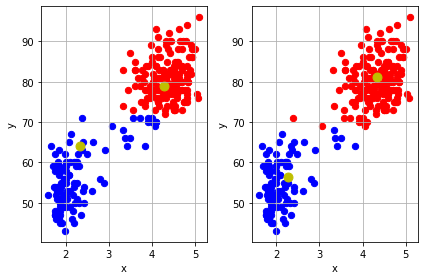

The current iteration of k-means is: 1,                the average loss is 33.97115028846499.


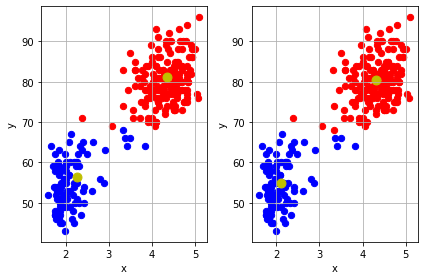

The current iteration of k-means is: 2,                the average loss is 32.73675733630585.


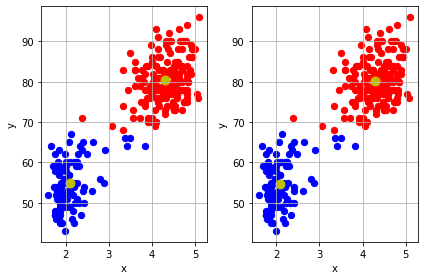

The current iteration of k-means is: 3,                the average loss is 32.72709088583533.


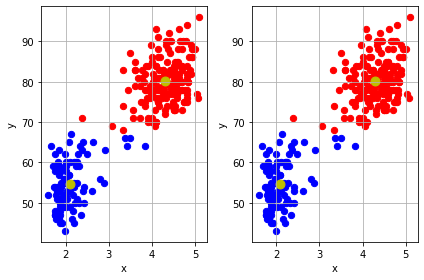

The current iteration of k-means is: 4,                the average loss is 32.72709088583533.


In [149]:
from helper import build_dir
from plots import plot

def kmeans(data, k, max_iters, threshold):
    """run the k-means algorithm."""
    output_figure = "kmeans_figures/"
    # initialize the cluster.
    mu_old = initialize_clusters(data, k)
    # init some empty lists to store the result.
    loss_list = []

    # start the kmeans algorithm.
    for iter in range(max_iters):
        # update z and mu
        losses, assignments, mu = update_kmeans_parameters(data, mu_old)
        # calculate the average loss over all points
        average_loss = np.mean(losses)
        loss_list.append(average_loss)
        print("The current iteration of k-means is: {i}, \
               the average loss is {l}.".format(i=iter, l=average_loss))
        # check converge
        if iter > 0 and np.abs(loss_list[-1] - loss_list[-2]) < threshold:
            break
        # output plot
        plot(data, mu, mu_old, output_figure + "kmean_iter{i}".format(i=iter))
        # update k-means information.
        mu_old = mu

# define parameters
k = 2
max_iters = 10
threshold = 1e-5
output_figure = "kmeans_figures/"

# build figure dir
build_dir(output_figure)
#np.random.seed(10)
# run kmeans algorithm
kmeans(data, k, max_iters, threshold)

## Using k-means for image compresson

#### load image

In [74]:
from helper import load_image

image_path = "mandrill.png"
original_image = load_image(image_path)
print(
    "Original image: the shape of image={s}, the data type={dt}.".format(
        s=original_image.shape, dt=original_image.dtype))

Original image: the shape of image=(480, 480, 3), the data type=float32.


#### preprocess image

In [83]:
def preprocess_image(original_image):
    """preprocess the image."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: make pixel values of each color (which is a matrix) 
    # into a vector. **don't normalize!**
    # ***************************************************  
    return original_image.reshape(-1, 3).copy()

processed_image = preprocess_image(original_image)

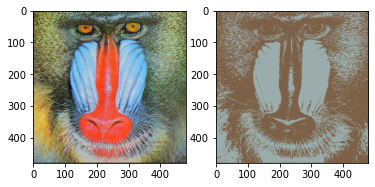

<Figure size 432x288 with 0 Axes>

In [154]:
from plots import plot_image_compression

def kmean_compression(original_image, processed_image, k, max_iters, threshold):
    """using k-means for image compression."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: use kmean to compress the image.
    # ***************************************************
    mu = initialize_clusters(processed_image, k)
    prev_loss = np.infty
    
    for i in range(max_iters):
        loss, assignments, mu = update_kmeans_parameters(processed_image, mu)
        loss = loss.mean()
        
        # Check convergence
        if abs(loss - prev_loss) < threshold:
            break
        
        prev_loss = loss

    # plot histogram
    plot_image_compression(original_image, processed_image, assignments, mu, k)

# define parameters
k = 2
max_iter = 100
threshold = 1e-6

# use kmeans to compress image
kmean_compression(original_image, processed_image, k, max_iter, threshold);

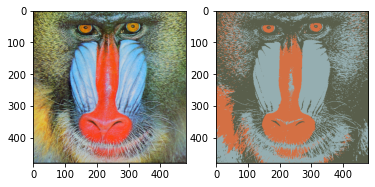

<Figure size 432x288 with 0 Axes>

In [155]:
k = 3
kmean_compression(original_image, processed_image, k, max_iter, threshold);

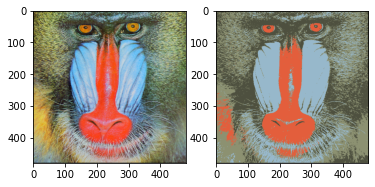

<Figure size 432x288 with 0 Axes>

In [157]:
k = 4
kmean_compression(original_image, processed_image, k, max_iter, threshold);

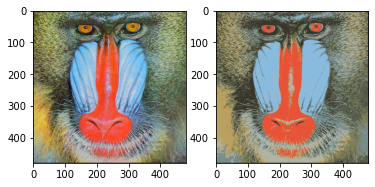

<Figure size 432x288 with 0 Axes>

In [162]:
k = 8
kmean_compression(original_image, processed_image, k, max_iter, threshold);

For instance, we could imagine to encode each pixel color with 4 bits -> 16 colors:

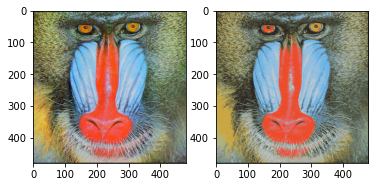

<Figure size 432x288 with 0 Axes>

In [161]:
k = 16
kmean_compression(original_image, processed_image, k, max_iter, threshold);